In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np

In [6]:
raw_data = pd.read_csv('bear_shot_logs.csv')
raw_data

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128064,21400006,"OCT 29, 2014 - BKN @ BOS",A,L,-16,5,3,1:52,18.3,5,...,8.7,2,missed,"Smart, Marcus",203935,0.8,0,0,jarrett jack,101127
128065,21400006,"OCT 29, 2014 - BKN @ BOS",A,L,-16,6,4,11:28,19.8,4,...,0.6,2,made,"Turner, Evan",202323,0.6,1,2,jarrett jack,101127
128066,21400006,"OCT 29, 2014 - BKN @ BOS",A,L,-16,7,4,11:10,23.0,2,...,16.9,2,made,"Thornton, Marcus",201977,4.2,1,2,jarrett jack,101127
128067,21400006,"OCT 29, 2014 - BKN @ BOS",A,L,-16,8,4,2:37,9.1,4,...,18.3,2,missed,"Bradley, Avery",202340,3.0,0,0,jarrett jack,101127


In [7]:
# Put player names in title case
raw_data['player_name'] = raw_data['player_name'].str.title()

In [8]:
# Extract teams from matchup series, rename cols usefully
matchup_split = raw_data['MATCHUP'].str.split(" - ",n=1,expand=True)
matchup_split = matchup_split.rename(columns = {
    0:'DATE',
    1:'TEAMS'
})

# Extract which team was shooting/defending, rename cols usefully
matchup_teams = matchup_split['TEAMS'].str.split(" ",expand=True)
matchup_teams = matchup_teams.rename(columns = {
    0:'SHOOTING_TEAM',
    2:'DEFENDING_TEAM'
})

# Drop unecessary &/vs
matchup_teams = matchup_teams[['SHOOTING_TEAM','DEFENDING_TEAM']]

# Join both mini-dfs
matchup_data = matchup_split.join(matchup_teams)
matchup_data = matchup_data[['DATE', 'SHOOTING_TEAM', 'DEFENDING_TEAM']]

# merge that new mini df into original df
data_matchup_highlighted = raw_data.join(matchup_data)

# identify useful columns to keep
cols_keep = ['GAME_ID','PTS_TYPE','LOCATION','SHOT_RESULT','SHOOTING_TEAM','player_name','PTS', 'FGM']

# Create overall dataset focused on relevant cols, and reordered cols usefully
clean_data = data_matchup_highlighted[cols_keep]

In [9]:
print(f"There are {len(clean_data['player_name'].unique())} identified players in the NBA.")

phi_data = clean_data[clean_data['SHOOTING_TEAM'] == 'PHI']
print(f"There are {len(phi_data['player_name'].unique())} identified players on the 76ers.")

There are 281 identified players in the NBA.
There are 9 identified players on the 76ers.


In [10]:
# We need to filter this such that only the defenders with 328 (4.0 shots/team game) instances of being the closest defender.
qualifying_shots = 82*4.0

# Get a count of how many times that player has shot the ball (considered an shot)
qual_data = clean_data.value_counts('player_name').to_frame()
qual_data = qual_data.rename(columns = {0:'SHOTS'})

# Join that data into the main df
shots_data = clean_data.join(qual_data,on='player_name')

# Filter for just 'qualified players', i.e., players with enough shots per team game
qualified_data = shots_data[shots_data['SHOTS'] >= qualifying_shots]
print(f"There are {len(qualified_data['player_name'].unique())} qualified players in the NBA.")

# Look at how many qualified players we have
phi_qual = qualified_data[qualified_data['SHOOTING_TEAM'] == 'PHI']
print(f"There are {len(phi_qual['player_name'].unique())} qualified players on the 76ers.")


There are 186 qualified players in the NBA.
There are 7 qualified players on the 76ers.


In [11]:
phi_qual

,GAME_ID,PTS_TYPE,LOCATION,SHOT_RESULT,SHOOTING_TEAM,player_name,PTS,FGM,SHOTS
71063,21400881,3,A,missed,PHI,Robert Covington,0,0,510
71064,21400881,2,A,missed,PHI,Robert Covington,0,0,510
71065,21400881,3,A,missed,PHI,Robert Covington,0,0,510
71066,21400881,2,A,missed,PHI,Robert Covington,0,0,510
71067,21400881,2,A,made,PHI,Robert Covington,2,1,510
...,...,...,...,...,...,...,...,...,...
74771,21400005,2,A,missed,PHI,Henry Sims,0,0,423
74772,21400005,2,A,missed,PHI,Henry Sims,0,0,423
74773,21400005,2,A,missed,PHI,Henry Sims,0,0,423
74774,21400005,2,A,made,PHI,Henry Sims,2,1,423


In [12]:
# Filter for just two-pointers
twos_data = qualified_data[(qualified_data['PTS'] == 2)]
# Count how many points they got from 2 pointers, put into mini df
twos_counts = 2*twos_data.value_counts(['player_name','GAME_ID']).to_frame()
twos_counts = twos_counts.rename(columns = {0:'2PT_PTS'})

# Filter for just three-pointers
tris_data = qualified_data[(qualified_data['PTS'] == 3)]
# Count how many points they got from 3 pointers, put into mini df
tris_counts = 3*tris_data.value_counts(['player_name','GAME_ID']).to_frame()
tris_counts = tris_counts.rename(columns = {0:'3PT_PTS'})

# Put two-pointer attempt counts into main df
qual_pts_type_disagg = qualified_data.join(twos_counts,on=['player_name','GAME_ID'])
# Then put three-pointer attempt counts into main df
qual_pts_type_disagg = qual_pts_type_disagg.join(tris_counts,on=['player_name','GAME_ID'])

# If they had no opportunites, that turn that NaN into a 0
qual_pts_type_disagg['2PT_PTS'] = qual_pts_type_disagg['2PT_PTS'].fillna(0)
qual_pts_type_disagg['3PT_PTS'] = qual_pts_type_disagg['3PT_PTS'].fillna(0)

In [13]:
quals_made = qual_pts_type_disagg
quals_made.columns

Index(['GAME_ID', 'PTS_TYPE', 'LOCATION', 'SHOT_RESULT', 'SHOOTING_TEAM',
       'player_name', 'PTS', 'FGM', 'SHOTS', '2PT_PTS', '3PT_PTS'],
      dtype='object')

In [14]:
# Narrow down the columns again
keep_cols = ['GAME_ID','player_name','LOCATION','SHOOTING_TEAM','2PT_PTS','3PT_PTS']
qual_focus = quals_made[keep_cols]

# Drop dupes will give us one row, per player, per game
# That row summarizes all shot data for that player, for that game
trim_qual = qual_focus.drop_duplicates(subset=['player_name','GAME_ID'])
trim_qual_phi = trim_qual[trim_qual['SHOOTING_TEAM'] == 'PHI']


In [15]:
# Looking just at 76ers data
trim_qual_phi[trim_qual_phi['player_name'] == 'Robert Covington']

,GAME_ID,player_name,LOCATION,SHOOTING_TEAM,2PT_PTS,3PT_PTS
71063,21400881,Robert Covington,A,PHI,6.0,6.0
71074,21400857,Robert Covington,H,PHI,2.0,6.0
71083,21400847,Robert Covington,A,PHI,2.0,9.0
71089,21400830,Robert Covington,A,PHI,6.0,9.0
71104,21400825,Robert Covington,A,PHI,6.0,9.0
71117,21400804,Robert Covington,H,PHI,4.0,0.0
71127,21400775,Robert Covington,H,PHI,4.0,3.0
71132,21400761,Robert Covington,H,PHI,4.0,15.0
71147,21400750,Robert Covington,A,PHI,6.0,9.0
71160,21400726,Robert Covington,H,PHI,4.0,6.0


In [16]:
# Separate data into away/home
qual_a = trim_qual_phi[trim_qual_phi['LOCATION'] == 'A']
qual_h = trim_qual_phi[trim_qual_phi['LOCATION'] == 'H']

# Find average of all away games for each person
mean_away = qual_a.groupby('player_name').mean(numeric_only=True)

# Find average of all home games for each person
mean_home = qual_h.groupby('player_name').mean(numeric_only=True)

# cut out game id now that we don't need it
mean_away = mean_away[['2PT_PTS', '3PT_PTS']]
mean_home = mean_home[['2PT_PTS', '3PT_PTS']]

mean_total = mean_home.join(mean_away, lsuffix='_HOME', rsuffix='_AWAY')
mean_total

,2PT_PTS_HOME,3PT_PTS_HOME,2PT_PTS_AWAY,3PT_PTS_AWAY
player_name,,,,
Henry Sims,6.428571,0.321429,7.096774,0.096774
Hollis Thompson,2.538462,4.269231,2.833333,4.375000
Kj Mcdaniels,5.666667,3.000000,4.000000,2.111111
Luc Mbah A Moute,5.692308,2.423077,6.370370,2.222222
Michael Carter-Williams,10.500000,2.100000,9.047619,2.571429
Nerles Noel,7.769231,0.000000,6.193548,0.000000
Robert Covington,2.869565,7.043478,4.480000,7.080000


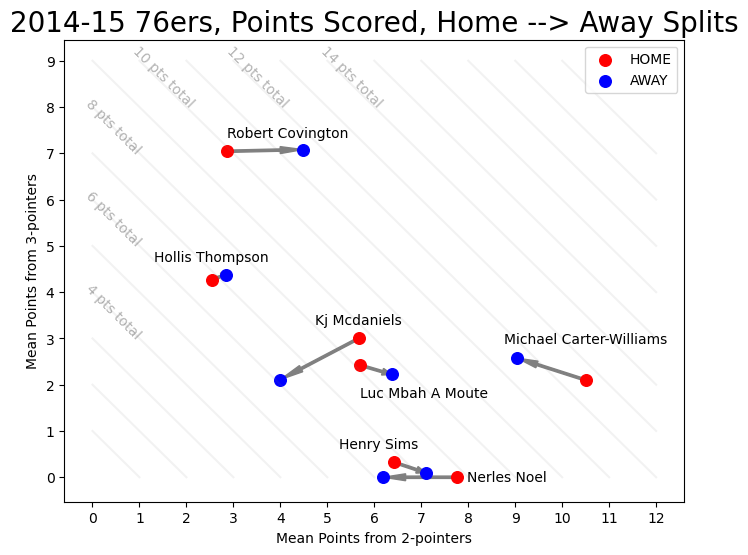

In [17]:
plt.figure(figsize=(8,6))

plt.xticks(np.arange(0,13,1))
plt.yticks(np.arange(0,10,1))

plt.title("2014-15 76ers, Points Scored, Home --> Away Splits", fontsize=20)
plt.xlabel("Mean Points from 2-pointers")
plt.ylabel("Mean Points from 3-pointers")

for n in range(0,20):
    x_0 = np.linspace(max(0,n-9),min(12,n),100)
    y_0 = n-(x_0)
    plt.plot(x_0, y_0,
             color = 'grey',
             alpha = 0.1
            )

## Point total background lines and labels
# kwargs for style
pt_total_rot = -45
pt_total_alpha = 0.3

# x-positions of the labels
xs = [5,3,1,0,0,0]

# trying 
for k in range(6):
    ys = 15-2*k       #y positions of the labels
    ps = 16 - 2*k     #pt totals that each line represents
    plt.text(xs[k]-.2,13-(2*k)-xs[k],f"{14-(2*k)} pts total",
             rotation = pt_total_rot,
             alpha = pt_total_alpha
            )

x = mean_total['2PT_PTS_HOME']
y = mean_total['3PT_PTS_HOME']
dx = mean_total['2PT_PTS_AWAY'] - mean_total['2PT_PTS_HOME']
dy = mean_total['3PT_PTS_AWAY'] - mean_total['3PT_PTS_HOME']

h_adj = [.5,0,0,0,0,.2,0]
v_adj = [.3,.4,.3,-.7,.8,-.1,.3]
ha = ['right','center','center','left','center','left','left']

for i in range(len(mean_total)):
    plt.arrow(x[i],y[i],dx[i],dy[i],
              width = 0.05,
              color = 'grey',
              head_length = abs(0.3*dx[i]),
              length_includes_head = True)
    plt.text(x[i]+h_adj[i],y[i]+v_adj[i],
             mean_total.index[i],
             ha = ha[i]
            )

plt.scatter(mean_total['2PT_PTS_HOME'], 
            mean_total['3PT_PTS_HOME'],
            s=70,
            color = 'red',
            label = 'HOME'
           )

plt.scatter(mean_total['2PT_PTS_AWAY'], 
            mean_total['3PT_PTS_AWAY'],
            s=70,
            color = 'blue',
            label = 'AWAY'
           )

plt.legend()

plt.savefig('bear_homeaway_splits')

plt.show()
